# Data Challenge

## 1. Import Modules

In [31]:
# data manipulation modules
import numpy as np
import pandas as pd

# data visualization modules
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

# data preprocessing modules
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold

# machine learning modeling modules
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import xgboost as xgb

from subprocess import check_output
import os
print(check_output(["ls", "./"]).decode("utf8"))

Challenge 12.ipynb
borrower_table.csv
loan_table.csv



## 2. Load Data

In [2]:
borrow = pd.read_csv('./borrower_table.csv')
df = pd.read_csv('./loan_table.csv')

In [3]:
def should(x):
    result = 0
    if x['loan_granted'] == 1 and x['loan_repaid'] == 1:
        result = 1
    return pd.Series({'should_grant':result})
# df['should_granted'] = df.apply(should, axis = 1)
df['should_granted'] = df.apply(lambda x: 1 if x['loan_granted'] == 1 and x['loan_repaid'] == 1 else 0, axis = 1)
df['profit'] = df.loan_repaid
df['profit'].replace(0, -1, inplace = True)
df['profit'].fillna(0, inplace = True)
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,should_granted,profit
0,19454,investment,2012-03-15,0,NaN,0,0.0
1,496811,investment,2012-01-17,0,NaN,0,0.0
2,929493,other,2012-02-09,0,NaN,0,0.0
3,580653,other,2012-06-27,1,1.0,1,1.0
4,172419,business,2012-05-21,1,0.0,0,-1.0


## 3. Exploratory Data Analysis

In [4]:
df.head() # take a look at data

,loan_id,loan_purpose,date,loan_granted,loan_repaid,should_granted,profit
0,19454,investment,2012-03-15,0,NaN,0,0.0
1,496811,investment,2012-01-17,0,NaN,0,0.0
2,929493,other,2012-02-09,0,NaN,0,0.0
3,580653,other,2012-06-27,1,1.0,1,1.0
4,172419,business,2012-05-21,1,0.0,0,-1.0


In [5]:
borrow.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [6]:
df = pd.merge(df, borrow, on = 'loan_id', how = 'left')

In [7]:
print('df.shape:', df.shape) # check dimensions

df.shape: (101100, 18)


In [8]:
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,should_granted,profit,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,0,0.0,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,0,0.0,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,0,0.0,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,0,-1.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [9]:
df.dtypes # check data types

loan_id                                              int64
loan_purpose                                        object
date                                                object
loan_granted                                         int64
loan_repaid                                        float64
should_granted                                       int64
profit                                             float64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int

In [10]:
df.describe() # check distribution of numeric vriables and check outliers

,loan_id,loan_granted,loan_repaid,should_granted,profit,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
count,101100.000000,101100.000000,47654.000000,101100.000000,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,0.471355,0.644353,0.303719,0.136083,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748
std,288662.006929,0.499181,0.478714,0.459865,0.672935,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491
min,30.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
25%,250333.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000
50%,499885.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000
75%,749706.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000
max,999987.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000


In [11]:
df.isnull().sum() # check missing values

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
should_granted                                         0
profit                                                 0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number               

In [12]:
df['loan_purpose'].value_counts() # check distribution of categorical variables

home               24314
business           21707
investment         21484
emergency_funds    18091
other              15504
Name: loan_purpose, dtype: int64

## 4. Data Visualization

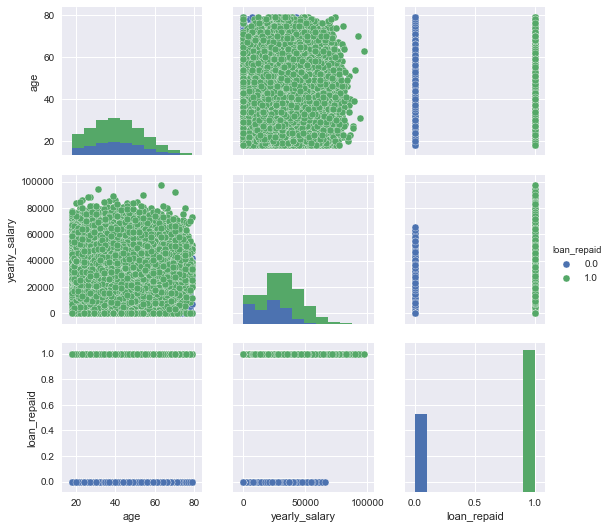

In [27]:
sns.pairplot(df[['age','yearly_salary','loan_repaid']], hue = 'loan_repaid') 
# check relationship between numeric vairables and respond variable

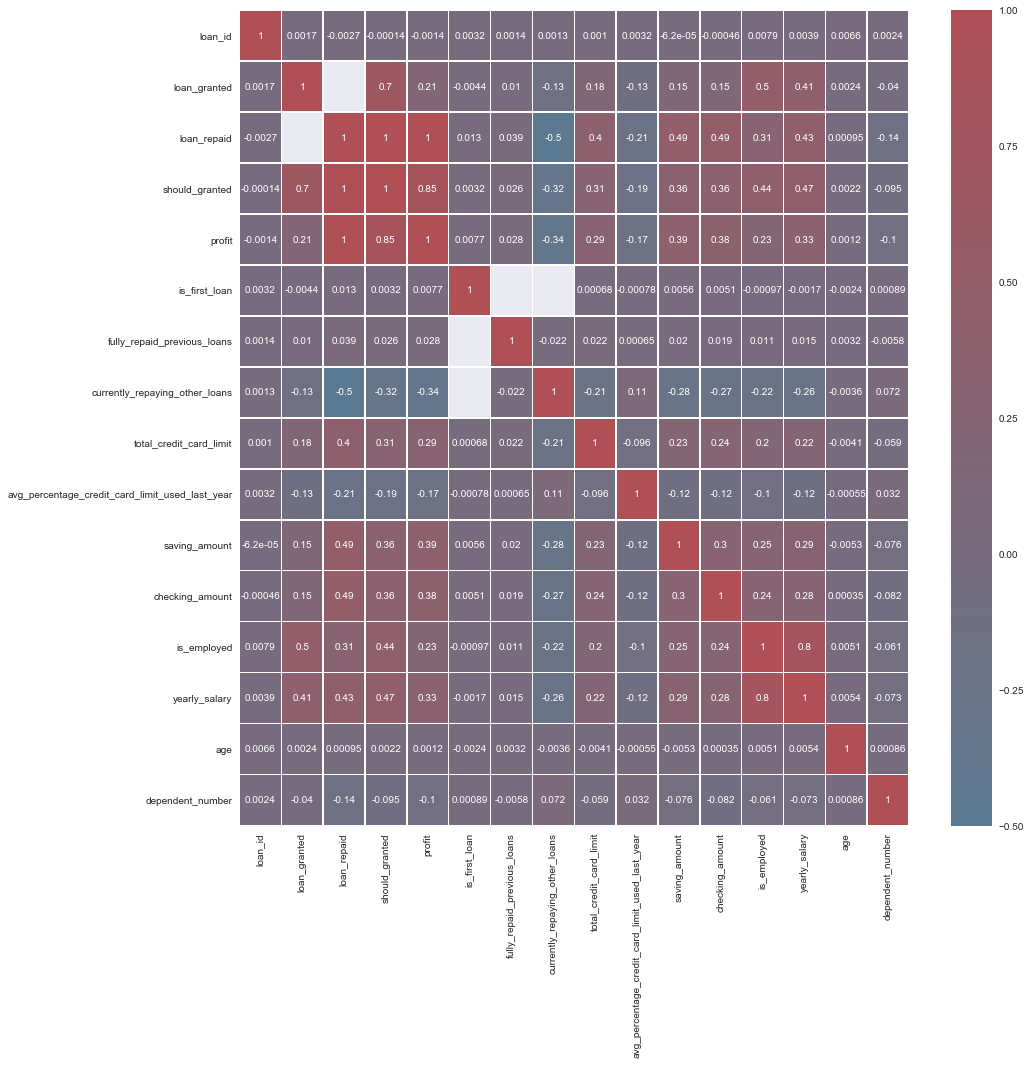

In [13]:
def corr_heatmap(data, value_range):
    cmap = mcolors.LinearSegmentedColormap.from_list("n",['#5B7A91', '#AF4F56'])
    vmin = value_range[0]
    vmax = value_range[1]
    vmean = (vmin + vmax) / 2
    corr_matrix = data.corr()
    fig = plt.subplots(1, 1, figsize=(15,15))
    sns.heatmap(corr_matrix, linewidth = 0.5, center = vmean, annot = True, cmap = cmap, vmin = vmin, vmax = vmax)
    return

corr_heatmap(df,[-0.5,1])

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

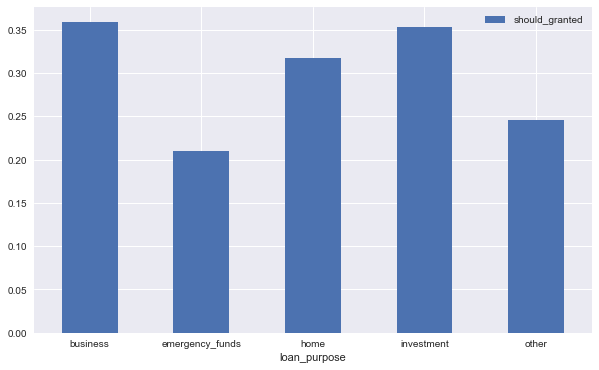

In [14]:
df[['loan_purpose','should_granted']].groupby('loan_purpose').mean().plot.bar(figsize = (10,6))
plt.xticks(rotation = 0)
# check relationship between categorical variables and respond variable
# fig, ax = plt.subplots(figsize = (10,6))
# fig = sns.barplot('variable', mean_response, data = df)
# fig.axis(ymin = ..., ymax = ...)
# plt.xticks(rotation = 45)

## 5. Data Preprocessing

In [15]:
df['avg_percentage_credit_card_limit_used_last_year'].fillna(df['avg_percentage_credit_card_limit_used_last_year'].median(), inplace = True) # use median to impute
df['avg_percentage_credit_card_limit_used_last_year'].isnull().sum()
# numeric missing data imputation

0

In [16]:
df.drop(['loan_granted','loan_repaid'], axis = 1, inplace = True)
df.isnull().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
should_granted                                         0
profit                                                 0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year        0
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [17]:
df['fully_repaid_previous_loans'].fillna(-1, inplace = True) # use median to impute
df['fully_repaid_previous_loans'].isnull().sum()

0

In [18]:
df['currently_repaying_other_loans'].fillna(-1, inplace = True) # use median to impute
df['currently_repaying_other_loans'].isnull().sum()

0

In [20]:
# df['variable'].replace(outlier, df['variable'].median, inplace = True) # use median to replace
# (df['variable'] == outlier).sum()
# outlier/weried data replace

In [21]:
df.isnull().sum()

loan_id                                            0
loan_purpose                                       0
date                                               0
should_granted                                     0
profit                                             0
is_first_loan                                      0
fully_repaid_previous_loans                        0
currently_repaying_other_loans                     0
total_credit_card_limit                            0
avg_percentage_credit_card_limit_used_last_year    0
saving_amount                                      0
checking_amount                                    0
is_employed                                        0
yearly_salary                                      0
age                                                0
dependent_number                                   0
dtype: int64

In [ ]:
dict1 = {'mis-match':'real_value'}
df['variable'].replace(dict1, inplace = True)
df['variable'].value_counts()
# deal with categorical mis-match

In [273]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['dow'] = df['date'].dt.dayofweek

In [274]:
df.dtypes

loan_id                                                     int64
loan_purpose                                               object
date                                               datetime64[ns]
should_granted                                              int64
profit                                                    float64
is_first_loan                                               int64
fully_repaid_previous_loans                               float64
currently_repaying_other_loans                            float64
total_credit_card_limit                                     int64
avg_percentage_credit_card_limit_used_last_year           float64
saving_amount                                               int64
checking_amount                                             int64
is_employed                                                 int64
yearly_salary                                               int64
age                                                         int64
dependent_

In [26]:
data = pd.get_dummies(df.drop('date', axis = 1), drop_first = True)
# one-hot encoding

In [32]:
data.head()

,loan_id,should_granted,profit,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other
0,19454,0,0.0,1,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0,1,0
1,496811,0,0.0,1,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0,1,0
2,929493,0,0.0,1,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4,0,0,0,1
3,580653,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,0,0,0,1
4,172419,0,-1.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,0,0,0,0


In [28]:
# y = df['loan_repaid']
# X = scale(df.drop(['loan_granted','loan_id','loan_repaid'], axis = 1))

# knn = KNeighborsClassifier(n_neighbors=7, p = 1) # p = 1 use Manhattan distance, p = 2 use Euclidean distance
# knn.fit(X, y)
# df['knn'] = knn.predict(X)
# feature engineering with KNN

## 6. Predictive Modeling

In [38]:
y = data['should_granted']
X = data.drop(['loan_id','should_granted','profit'], axis = 1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 1919)
# split data into train and test for validation

In [39]:
kf = KFold(n_splits=5, shuffle = True)
rf = RandomForestClassifier(n_estimators=500)
for train_index, test_index in kf.split(X):
    Xtrain, Xtest = X.iloc[train_index,:], X.iloc[test_index,:]
    ytrain, ytest = y[train_index], y[test_index]
    rf.fit(Xtrain, ytrain)
    ypred = rf.predict(Xtest)
    print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.92      0.84      0.88     14007
          1       0.70      0.84      0.76      6213

avg / total       0.85      0.84      0.84     20220

             precision    recall  f1-score   support

          0       0.92      0.84      0.88     14019
          1       0.70      0.84      0.77      6201

avg / total       0.86      0.84      0.85     20220

             precision    recall  f1-score   support

          0       0.93      0.84      0.88     14199
          1       0.70      0.85      0.77      6021

avg / total       0.86      0.84      0.85     20220

             precision    recall  f1-score   support

          0       0.92      0.84      0.88     14056
          1       0.70      0.84      0.76      6164

avg / total       0.86      0.84      0.85     20220

             precision    recall  f1-score   support

          0       0.92      0.84      0.88     14113
          1       0.70      0.84 

In [37]:
Xtrain.head()

,profit,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other
0,0.0,1,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0,1,0
1,0.0,1,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0,1,0
2,0.0,1,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4,0,0,0,1
3,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,0,0,0,1
4,-1.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,0,0,0,0


In [147]:
# KNN feature engineering
knn = KNeighborsClassifier(n_neighbors=7, p = 1) # p = 1 use Manhattan distance, p = 2 use Euclidean distance

scale_df = scale(pd.concat([Xtrain, Xtest], axis = 0))
scale_train = scale_df[:Xtrain.shape[0]]
scale_test = scale_df[Xtrain.shape[0]:]

scale_train = pd.DataFrame(scale_train, columns = Xtrain.columns)
scale_test = pd.DataFrame(scale_test,columns = Xtrain.columns)

knn.fit(scale_train, ytrain)

Xtrain['knn'] = knn.predict_proba(scale_train)[:,1]
Xtest['knn'] = knn.predict_proba(scale_test)[:,1]

Xtrain['knn'] = knn.predict_proba(scale_train)[:,1]
Xtest['knn'] = knn.predict_proba(scale_test)[:,1]
# time for knn feature engineering is 4-5 minutes for data shape of (38123, 20)

/Users/leonardguo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/leonardguo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/leonardguo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

255.26890182495117


/Users/leonardguo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [282]:
profit_test = Xtest.profit
Xtest = Xtest.drop(['profit'], axis = 1)
Xtrain = Xtrain.drop(['profit'], axis = 1)

In [283]:
# lr = LinearRegression()
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=500)
# rf = RandomForestClassifier(n_estimators=500)

lr.fit(Xtrain, ytrain)
ypred = lr.predict(Xtest)

coefficient = pd.DataFrame(list(Xtrain.columns))
coefficient.columns = ['Features']
coefficient['Coefficient'] = lr.coef_[0]

# z, p = get_p_value(logreg, Xtrain, ytrain)
# p = [round(i,3) for i in p]
# # s = get_significance(p)
# coefficient['z-score'] = z
# coefficient['p-value'] = p
# # coefficient['significance'] = s
coefficient.sort_values(by = ['Coefficient'], ascending = False)

,Features,Coefficient
7,is_employed,2.670665
5,saving_amount,0.000289
3,total_credit_card_limit,0.000213
6,checking_amount,0.000199
8,yearly_salary,0.000017
9,age,-0.003246
15,loan_purpose_investment,-0.003583
11,month,-0.008239
12,dow,-0.016932
1,fully_repaid_previous_loans,-0.037667


In [209]:
Xtrain.drop('knn', axis = 1).corr()

,is_first_loan,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,dow,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,fully_repaid_previous_loans_1.0,fully_repaid_previous_loans_Other,currently_repaying_other_loans_1.0,currently_repaying_other_loans_Other
is_first_loan,1.000000,0.001601,-0.006723,0.007594,0.010977,-0.002875,-0.004407,0.002787,-0.005505,-0.001074,0.000471,-0.013932,0.004188,0.002561,-0.003442,-0.913179,1.000000,-0.430452,1.000000
total_credit_card_limit,0.001601,1.000000,-0.078323,0.194557,0.204197,0.156719,0.186852,-0.002310,-0.061266,-0.003643,-0.000595,-0.054187,-0.001291,0.034367,-0.033074,0.008211,0.001601,-0.121919,0.001601
avg_percentage_credit_card_limit_used_last_year,-0.006723,-0.078323,1.000000,-0.100690,-0.104651,-0.085946,-0.103002,0.006171,0.025996,-0.000538,-0.004701,0.031809,-0.017581,-0.010341,0.022651,0.006603,-0.006723,0.057562,-0.006723
saving_amount,0.007594,0.194557,-0.100690,1.000000,0.238369,0.147852,0.209441,-0.003615,-0.065095,-0.006910,0.006316,-0.071899,0.013667,0.039575,-0.040114,-0.003527,0.007594,-0.153642,0.007594
checking_amount,0.010977,0.204197,-0.104651,0.238369,1.000000,0.151026,0.208744,0.005416,-0.072584,-0.000114,0.000358,-0.069896,0.011204,0.038809,-0.036449,-0.005410,0.010977,-0.152068,0.010977
is_employed,-0.002875,0.156719,-0.085946,0.147852,0.151026,1.000000,0.566255,0.005389,-0.042295,-0.008912,0.001478,-0.039746,0.011800,0.033480,-0.040240,0.004127,-0.002875,-0.091866,-0.002875
yearly_salary,-0.004407,0.186852,-0.103002,0.209441,0.208744,0.566255,1.000000,0.005830,-0.059104,-0.007800,0.000854,-0.062116,0.010229,0.038054,-0.040384,0.006825,-0.004407,-0.128315,-0.004407
age,0.002787,-0.002310,0.006171,-0.003615,0.005416,0.005389,0.005830,1.000000,-0.001604,-0.000155,0.000436,-0.015739,-0.004352,0.002504,0.006898,0.000161,0.002787,-0.006318,0.002787
dependent_number,-0.005505,-0.061266,0.025996,-0.065095,-0.072584,-0.042295,-0.059104,-0.001604,1.000000,-0.005384,-0.000345,0.011159,-0.016266,-0.005199,0.018096,0.004936,-0.005505,0.045704,-0.005505
month,-0.001074,-0.003643,-0.000538,-0.006910,-0.000114,-0.008912,-0.007800,-0.000155,-0.005384,1.000000,0.013363,-0.003716,0.002296,0.000320,0.002124,0.003068,-0.001074,0.008107,-0.001074


In [ ]:
# XGboost regression
dtrain = xgb.DMatrix(Xtrain, ytrain)
dvalid  = xgb.DMatrix(Xtest,  ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {
    'eta': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
model = xgb.train(params, dtrain, 250, watchlist, verbose_eval=50, early_stopping_rounds=30)

ypred = model.predict(xgb.DMatrix(Xtest), ntree_limit=model.best_ntree_limit)

# print('RMSE XGBoost: ', RMSLE(ydev, cv_pred))

In [108]:
ytrain_pred = lr.predict(Xtrain)
fig = plt.figure(figsize = (8,8)
plt.scatter(ytrain_pred, ytrain - ytrain_pred)
# residual plot

In [284]:
print(confusion_matrix(ytest, ypred))
#

[[12260  1899]
 [ 2015  4046]]


In [285]:
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.86      0.87      0.86     14159
          1       0.68      0.67      0.67      6061

avg / total       0.81      0.81      0.81     20220



In [290]:
# bank_profit = sum(ytest) * 1 - (len(ytest) - sum(ytest)) * 1
profit = pd.DataFrame({'profit':profit_test, 'ytest':ytest,'ypred':ypred})
profit.head()

,profit,ypred,ytest
72726,1.0,1,1
100073,-1.0,0,0
16646,1.0,0,1
76950,0.0,0,0
73290,0.0,0,0


In [300]:
bank_profit = profit.profit.sum()
bank_profit

2663.0

In [296]:
model_profit = profit[profit.ypred == 1].profit.sum()
model_profit

3994.0

In [297]:
rf = RandomForestClassifier(n_estimators=500)

rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

In [298]:
importance = rf.feature_importances_
feature = Xtrain.columns
imp = pd.DataFrame({'feature':feature,'importance':importance})
imp.sort_values(by = ['importance'], ascending = False)

,feature,importance
5,saving_amount,0.174054
8,yearly_salary,0.168407
6,checking_amount,0.155728
3,total_credit_card_limit,0.102787
4,avg_percentage_credit_card_limit_used_last_year,0.091308
7,is_employed,0.089352
9,age,0.059501
11,month,0.040527
10,dependent_number,0.033146
12,dow,0.026574


In [299]:
profit = pd.DataFrame({'profit':profit_test, 'ytest':ytest,'ypred':ypred})
model_profit = profit[profit.ypred == 1].profit.sum()
model_profit

4999.0

In [301]:
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[11838  2321]
 [  927  5134]]
             precision    recall  f1-score   support

          0       0.93      0.84      0.88     14159
          1       0.69      0.85      0.76      6061

avg / total       0.86      0.84      0.84     20220



In [144]:
test = pd.DataFrame({'grant':ypred, 'loan_repaid':ytest})
repay = test[test.grant == 1]['loan_repaid']
model_profit = 2*sum(repay) - (len(repay)) * 1
model_profit

5271.0

In [303]:
# XGboost regression
dtrain = xgb.DMatrix(Xtrain, ytrain)
dvalid  = xgb.DMatrix(Xtest,  ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {
    'eta': 0.03,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'silent': 1
}
model = xgb.train(params, dtrain, 500, watchlist, verbose_eval=50, early_stopping_rounds=30)

ypred = model.predict(xgb.DMatrix(Xtest), ntree_limit=model.best_ntree_limit)
# print('RMSE XGBoost: ', RMSLE(ydev, cv_pred))

[0]	train-logloss:0.679927	valid-logloss:0.679992
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[50]	train-logloss:0.387439	valid-logloss:0.396251
[100]	train-logloss:0.335954	valid-logloss:0.353463
[150]	train-logloss:0.319045	valid-logloss:0.345338
[200]	train-logloss:0.309301	valid-logloss:0.343729
[250]	train-logloss:0.301686	valid-logloss:0.343486
Stopping. Best iteration:
[248]	train-logloss:0.301927	valid-logloss:0.343438



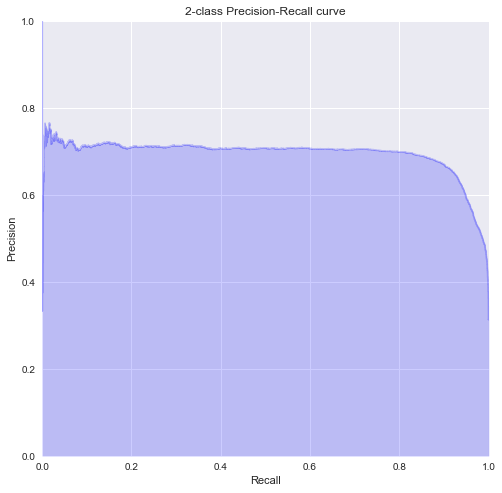

In [304]:
precision, recall, threshold = precision_recall_curve(ytest, ypred)
fig = plt.figure(figsize = (8,8))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

In [305]:
PR = pd.DataFrame({'threshold':threshold,'precision':precision[1:], 'recall':recall[1:]})
PR['F1'] = 2 * PR.precision * PR.recall / (PR.precision + PR.recall)
PR[PR.F1 == max(PR.F1)]

,precision,recall,threshold,F1
11297,0.674222,0.893252,0.357166,0.768434


In [182]:
threshold.shape

(8901,)

In [306]:
th = 0.357166
ypred = ypred > th

In [307]:
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[11542  2617]
 [  647  5414]]
             precision    recall  f1-score   support

          0       0.95      0.82      0.88     14159
          1       0.67      0.89      0.77      6061

avg / total       0.87      0.84      0.84     20220



In [308]:
profit = pd.DataFrame({'profit':profit_test, 'ytest':ytest,'ypred':ypred})
model_profit = profit[profit.ypred == 1].profit.sum()
model_profit

5139.0

In [194]:
test = pd.DataFrame({'grant':ypred, 'loan_repaid':ytest})
repay = test[test.grant == 1]['loan_repaid']
model_profit = 2*sum(repay) - (len(repay)) * 1
model_profit

5283.0

In [ ]:
auc()